In [1]:
import cv2
import pydicom
import numpy as np

test_img = cv2.imread("dataset/muryadi 9-img-00001-00001 (1).bmp")

In [2]:
def read_dcm_images(img_path: str) -> np.array:
    dcm_file = pydicom.read_file(img_path)
    return dcm_file.pixel_array

In [3]:
import cv2
import matplotlib.pyplot as plt

def plot_img(img, title="Image", cmap="gray"):
    """Plots an image using OpenCV and Matplotlib.

    Args:
        img: OpenCV image (grayscale or color).
        title: Optional title for the plot.
        cmap: Optional colormap for grayscale images.
    """

    # Convert BGR to RGB if necessary
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create the plot using Matplotlib
    plt.figure(figsize=(8, 6))  # Set a default figure size
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")  # Remove axis labels
    plt.show()

muryadi 10-img-00001-00001 (1)


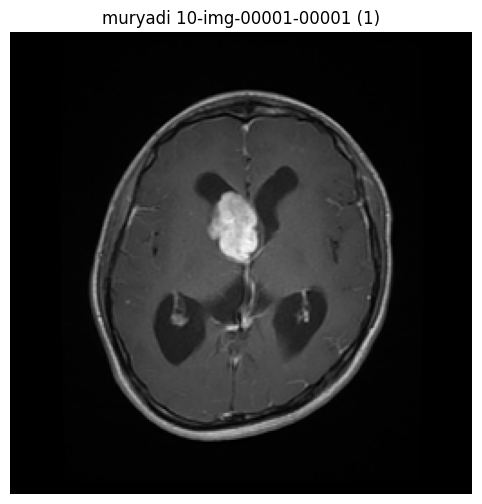

SAADAH 14-dicom-00001 (1)


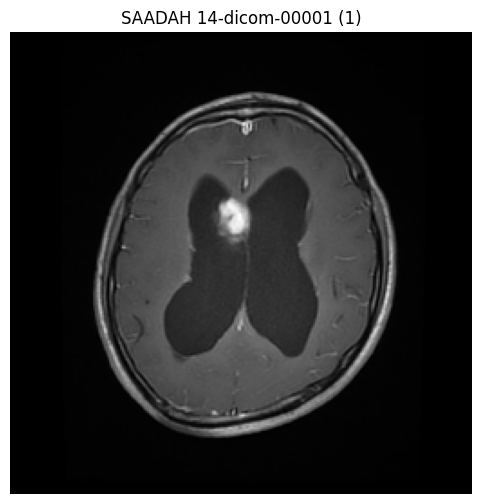

SAADAH 9-dicom-00001 (1)


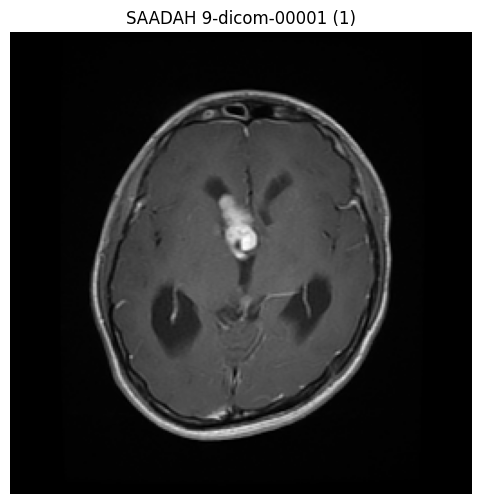

SAADAH 13-dicom-00001 (1)


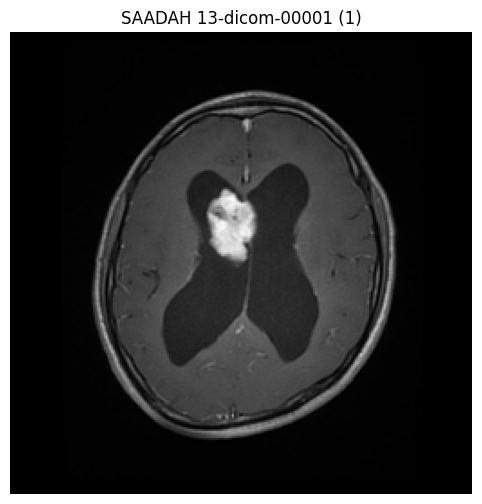

SAADAH 12-dicom-00001 (1)


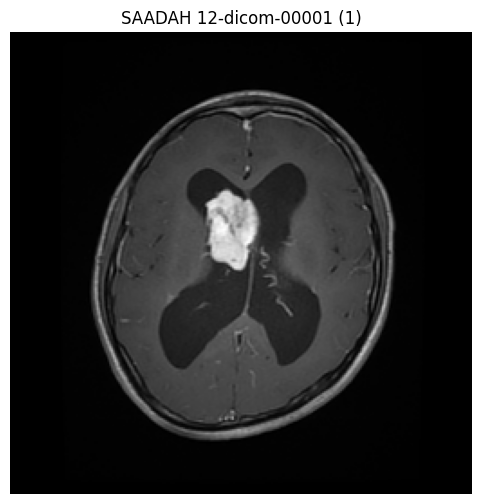

muryadi 11-img-00001-00001 (1)


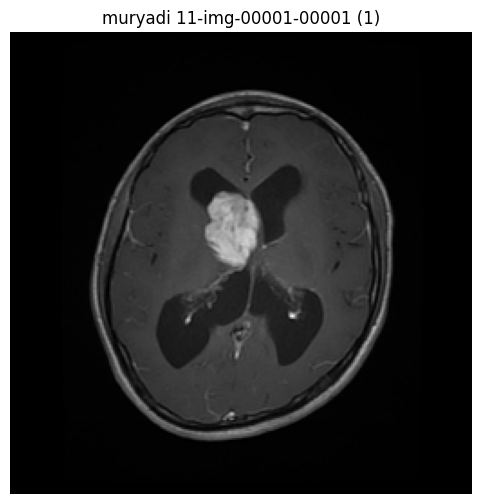

muryadi 9-img-00001-00001 (1)


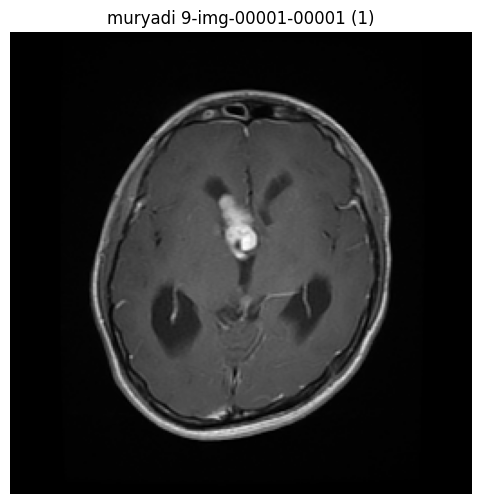

SAADAH 11-dicom-00001 (1)


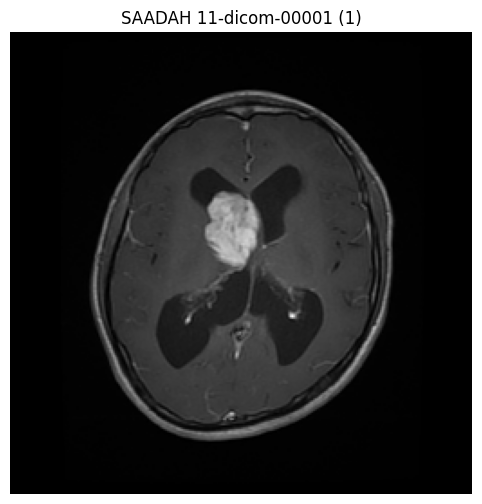

muryadi 12-img-00001-00001 (1)


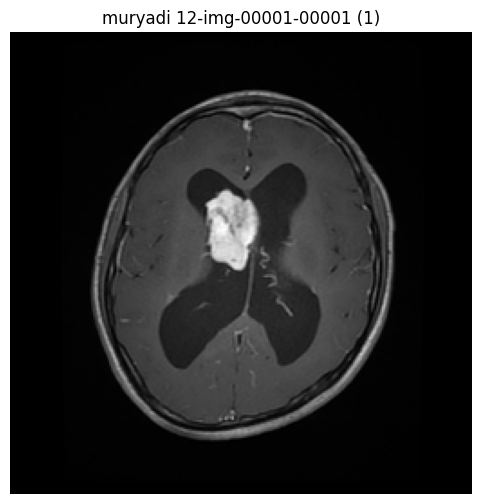

SAADAH 10-dicom-00001 (1)


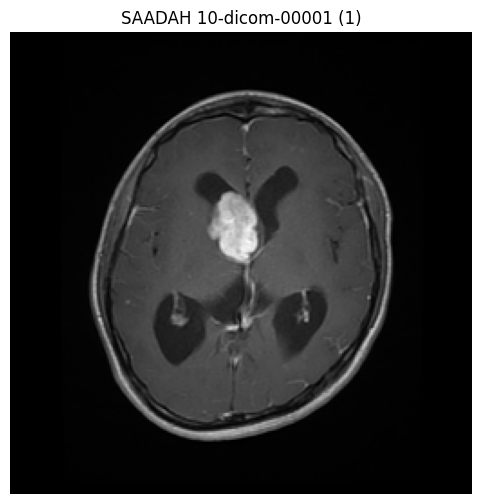

muryadi 14-img-00001-00001 (1)


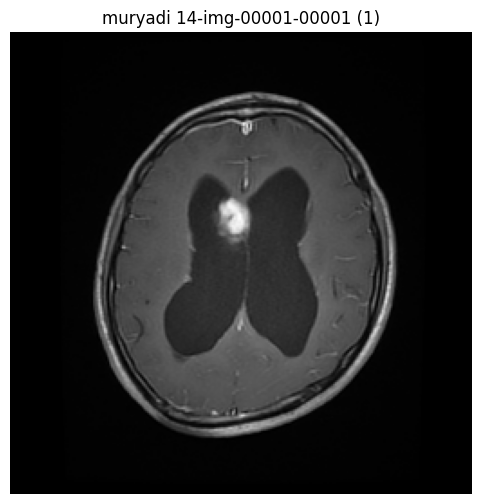

In [4]:
import glob
import os

DATASET_DIR = "dataset/"
list_read_img = []

for img_path in glob.glob(os.path.join(DATASET_DIR,"*")):
    img_ext = img_path.split(".")[-1]
    img_name = os.path.split(img_path)[-1].split(".")[0]
    print(img_name)
    img = None
    if img_ext == "dcm":
        img = read_dcm_images(img_path)
    else:
        img = cv2.imread(img_path)
    list_read_img.append(img)
    plot_img(img, title=img_name)

## Image Segmentation using Otsu Thresholding

In [5]:
# # reduce noise using gaussian blur
# list_reduced_noise_imgs = []
# for img in list_read_img:
#     new_img = cv2.GaussianBlur(img, (5, 5), 0)
#     plot_img(new_img)

In [6]:
def find_otsu_thresholding(image, is_normalized=False, bins_num=256):
    # Get the image histogram
    hist, bin_edges = np.histogram(image, bins=bins_num)
    
    # Get normalized histogram if it is required
    if is_normalized:
        hist = np.divide(hist.ravel(), hist.max())
    
    # Calculate centers of bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.
    
    # Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    
    # Get the class means mu0(t)
    mean1 = np.cumsum(hist * bin_mids) / weight1
    # Get the class means mu1(t)
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
    
    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    
    # Maximize the inter_class_variance function val
    index_of_max_val = np.argmax(inter_class_variance)
    
    threshold = bin_mids[:-1][index_of_max_val]
    return threshold

In [7]:
mean_otsu_thresholding = []

for img in list_read_img:
    mean_otsu_thresholding.append(find_otsu_thresholding(img, is_normalized=True))

mean_otsu_thresholding = sum(mean_otsu_thresholding) / len(mean_otsu_thresholding)

print(mean_otsu_thresholding)

40.16068892045455


In [8]:
# Create a mask to exclude black pixels
mask = (test_img > 5).astype(np.uint8) * 255

plot_img()

TypeError: plot_img() missing 1 required positional argument: 'img'

In [9]:
def image_segmentation_using_otsu_threshold(image, offset=110):
    if len(image.shape) > 2:
        # Convert the image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Check dark points. Take out pixel value < 5
    mask = (image > 5).astype(np.uint8) * 255

    # otsu thresholding
    otsu_threshold = find_otsu_thresholding(image)

    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(image, offset + otsu_threshold, 255, cv2.THRESH_BINARY)
    print(otsu_threshold)
    segmented_image = cv2.bitwise_and(segmented_image, segmented_image, mask)
    return segmented_image

In [52]:
def predict_tumor_segmentation(image):
    segmented_image = image_segmentation_using_otsu_threshold(image, offset=110)
    # roi_image = cv2.bitwise_and(img, img, mask=segmented_image)
    
    # Find contours in the segmented image
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the center of the image
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
    approx_start_x, approx_start_y = 0.3 * center_x, 0.5 * center_y
    print("center_x", center_x)
    print("center_y", center_y)
    print("approx_x", approx_start_x)
    print("approx_y", approx_start_y)

    # Initialize variables for top-left and bottom-right corners around the center
    centered_top_left_min = (float('inf'), float('inf'))
    centered_bottom_right_max = (0, 0)

    # Loop through each contour and update the top-left and bottom-right corners around the center
    for contour in contours:
        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Check if the contour is around the center of the image
        if center_x - approx_start_x < x < center_x + approx_start_x // 2 \
            and center_y - approx_start_y < y < center_y + approx_start_y:
            # Update the top-left corner around the center
            centered_top_left_min = (min(centered_top_left_min[0], x), min(centered_top_left_min[1], y))
            # Update the bottom-right corner around the center
            centered_bottom_right_max = (max(centered_bottom_right_max[0], x + w), max(centered_bottom_right_max[1], y + h))

    # Print the top-left and bottom-right corners around the center
    print(f"Top-left around the center: {centered_top_left_min}")
    print(f"Bottom-right around the center: {centered_bottom_right_max}")

    visualization_img = image.copy()
    # You can also draw a rectangle around all contours if needed
    cv2.rectangle(visualization_img, centered_top_left_min, centered_bottom_right_max, (0, 255, 0), 2)
    plot_img(visualization_img)

    # Crop the region of interest (ROI) from the original image
    cropped_roi = image[centered_top_left_min[1]:centered_bottom_right_max[1], centered_top_left_min[0]:centered_bottom_right_max[0]]
    plot_img(cropped_roi)

    segmented_image_roi = image_segmentation_using_otsu_threshold(cropped_roi, offset=20)
    roi_image = cv2.bitwise_and(cropped_roi, cropped_roi, mask=segmented_image_roi)
    plot_img(segmented_image_roi)

43.330078125
Top-left of top-left: (46, 34)
Bottom-right of bottom-right: (210, 224)


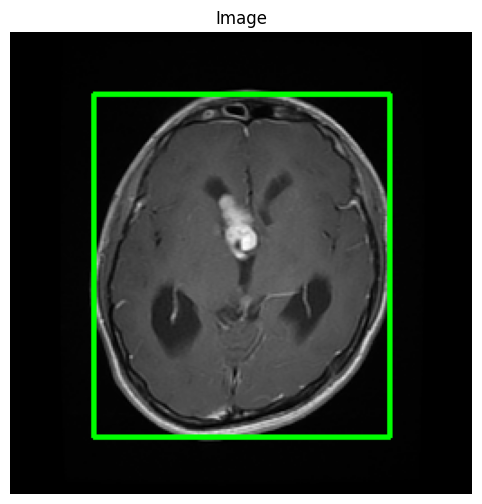

In [26]:
test_img = cv2.imread("dataset/muryadi 9-img-00001-00001 (1).bmp")
segmented_image = image_segmentation_using_otsu_threshold(test_img)
roi_image = cv2.bitwise_and(img, img, mask=segmented_image)
# Find contours in the segmented image
contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize variables for top-left and bottom-right corners
top_left_min = (float('inf'), float('inf'))
bottom_right_max = (0, 0)

# Loop through each contour and update the top-left and bottom-right corners
for contour in contours:
    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Update the top-left corner
    top_left_min = (min(top_left_min[0], x), min(top_left_min[1], y))

    # Update the bottom-right corner
    bottom_right_max = (max(bottom_right_max[0], x + w), max(bottom_right_max[1], y + h))

# Print the top-left and bottom-right corners
print(f"Top-left of top-left: {top_left_min}")
print(f"Bottom-right of bottom-right: {bottom_right_max}")

# You can also draw a rectangle around all contours if needed
new_img = cv2.rectangle(test_img, top_left_min, bottom_right_max, (0, 255, 0), 2)
plot_img(new_img)

In [ ]:
test_img = cv2.imread("dataset/muryadi 9-img-00001-00001 (1).bmp")
center_x, center_y = test_img.shape[1] // 2, test_img.shape[0] // 2
approx_start_x, approx_start_y = 0.3 * center_x, 0.3 * center_y
print("center_x", center_x)
print("center_y", center_y)
print("approx_x", approx_start_x)
print("approx_y", approx_start_y)


43.330078125
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (90, 92)
Bottom-right around the center: (137, 158)


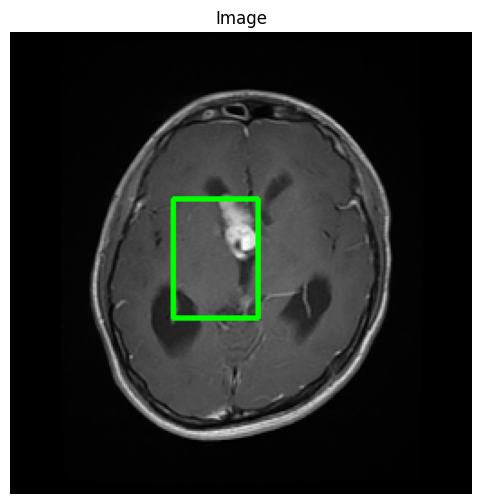

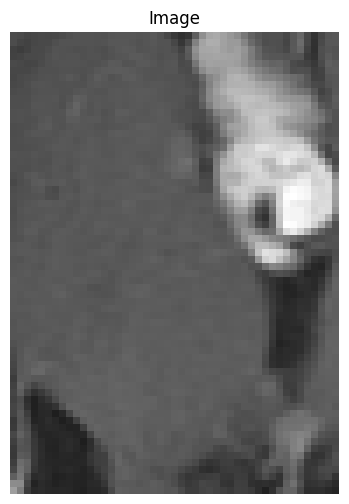

134.150390625


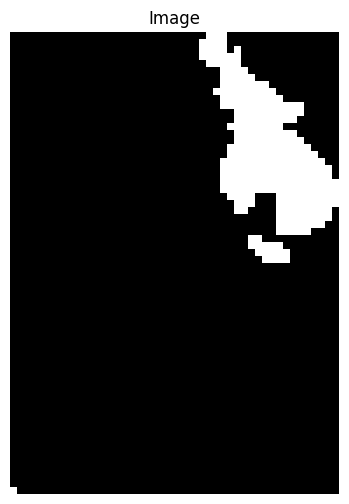

In [49]:
test_img = cv2.imread("dataset/muryadi 9-img-00001-00001 (1).bmp")
segmented_image = image_segmentation_using_otsu_threshold(test_img)
roi_image = cv2.bitwise_and(img, img, mask=segmented_image)

# Find contours in the segmented image
contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the center of the image
center_x, center_y = test_img.shape[1] // 2, test_img.shape[0] // 2
approx_start_x, approx_start_y = 0.3 * center_x, 0.5 * center_y
print("center_x", center_x)
print("center_y", center_y)
print("approx_x", approx_start_x)
print("approx_y", approx_start_y)

# Initialize variables for top-left and bottom-right corners around the center
centered_top_left_min = (float('inf'), float('inf'))
centered_bottom_right_max = (0, 0)

# Loop through each contour and update the top-left and bottom-right corners around the center
for contour in contours:
    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Check if the contour is around the center of the image
    if center_x - approx_start_x < x < center_x + approx_start_x // 2 \
         and center_y - approx_start_y < y < center_y + approx_start_y:
        # Update the top-left corner around the center
        centered_top_left_min = (min(centered_top_left_min[0], x), min(centered_top_left_min[1], y))
        # Update the bottom-right corner around the center
        centered_bottom_right_max = (max(centered_bottom_right_max[0], x + w), max(centered_bottom_right_max[1], y + h))

# Print the top-left and bottom-right corners around the center
print(f"Top-left around the center: {centered_top_left_min}")
print(f"Bottom-right around the center: {centered_bottom_right_max}")

visualization_img = test_img.copy()
# You can also draw a rectangle around all contours if needed
cv2.rectangle(visualization_img, centered_top_left_min, centered_bottom_right_max, (0, 255, 0), 2)
plot_img(visualization_img)

# Crop the region of interest (ROI) from the original image
cropped_roi = test_img[centered_top_left_min[1]:centered_bottom_right_max[1], centered_top_left_min[0]:centered_bottom_right_max[0]]
plot_img(cropped_roi)

segmented_image_roi = image_segmentation_using_otsu_threshold(cropped_roi, offset=20)
roi_image = cv2.bitwise_and(cropped_roi, cropped_roi, mask=segmented_image_roi)
plot_img(segmented_image_roi)

43.330078125
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (90, 92)
Bottom-right around the center: (137, 158)


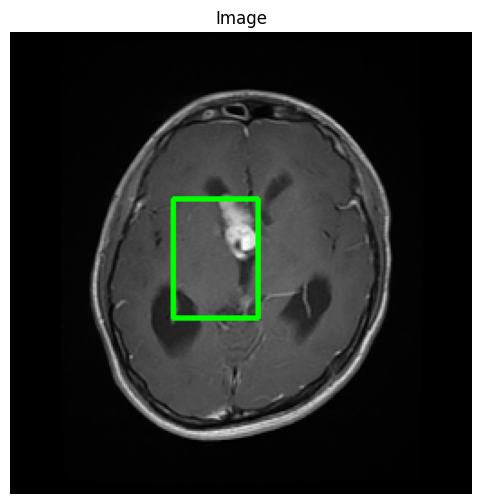

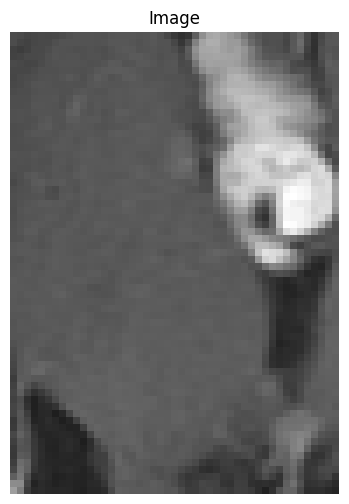

134.150390625


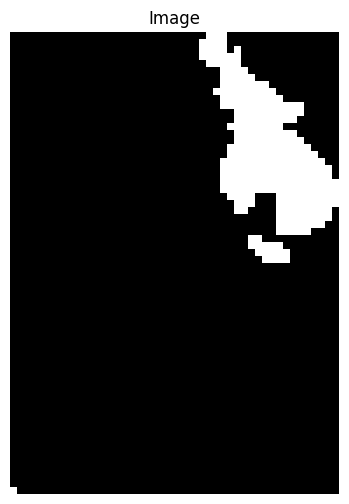

In [53]:
test_img = cv2.imread("dataset/muryadi 9-img-00001-00001 (1).bmp")
predicted_mask = predict_tumor_segmentation(test_img)

41.337890625
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (112, 89)
Bottom-right around the center: (137, 183)


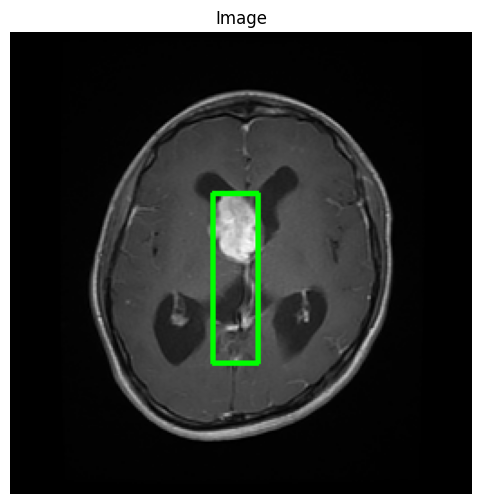

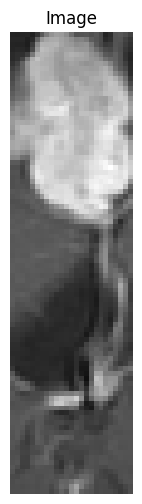

129.84375


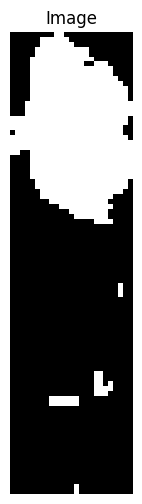

41.337890625
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (116, 82)
Bottom-right around the center: (132, 165)


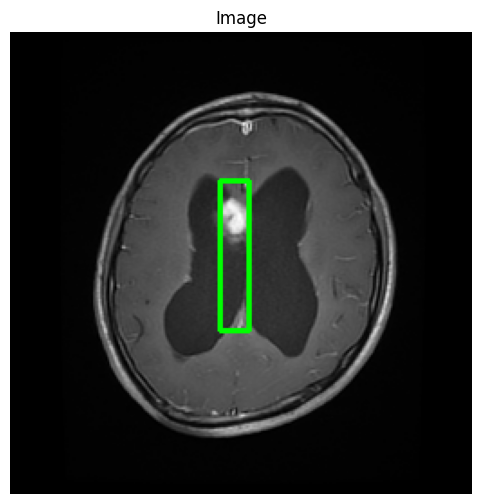

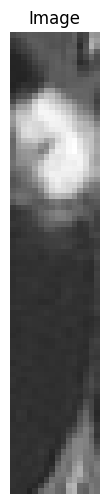

128.2421875


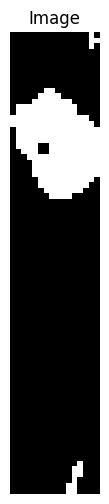

43.330078125
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (90, 92)
Bottom-right around the center: (137, 158)


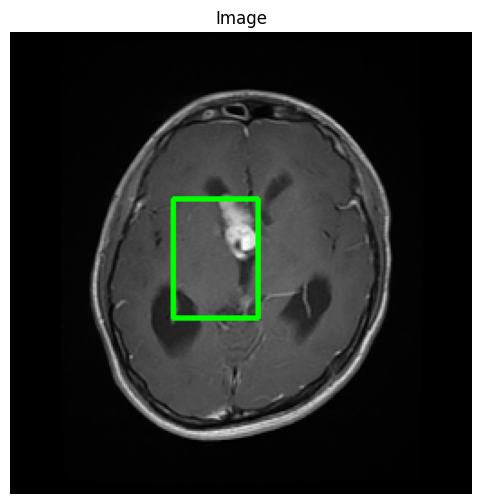

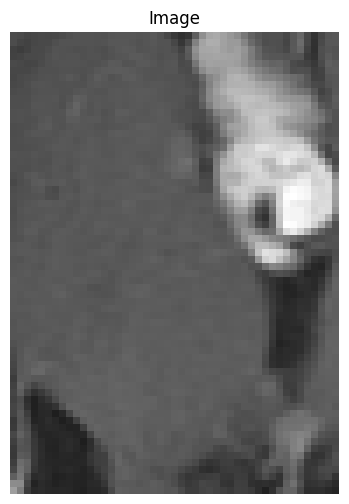

134.150390625


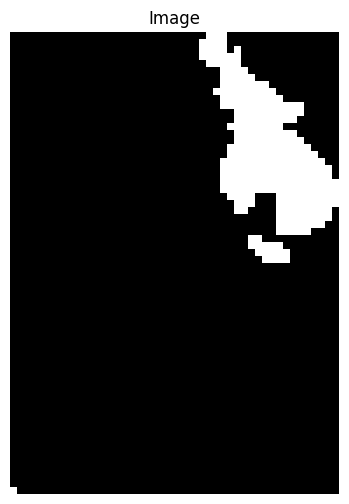

38.349609375
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (110, 88)
Bottom-right around the center: (135, 167)


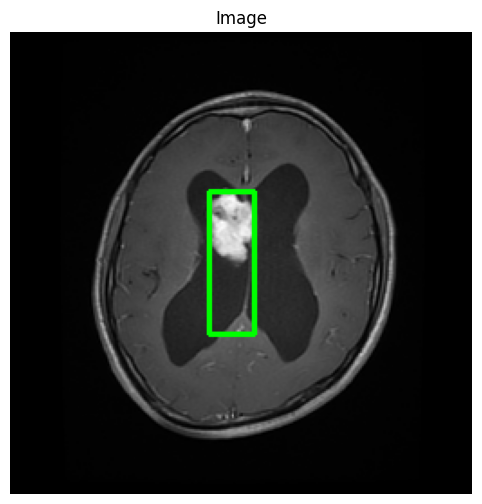

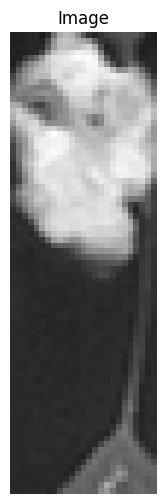

125.095703125


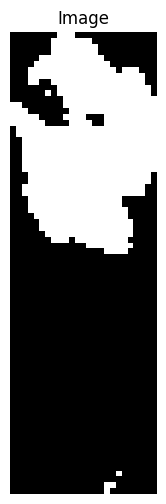

40.341796875
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (109, 75)
Bottom-right around the center: (137, 132)


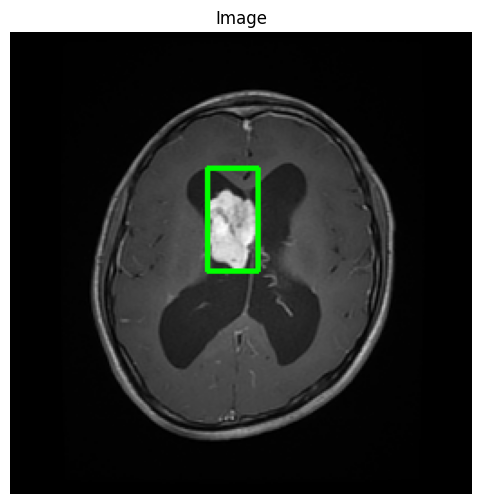

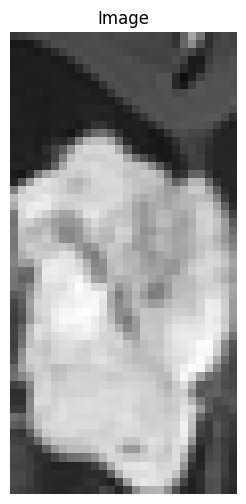

128.80078125


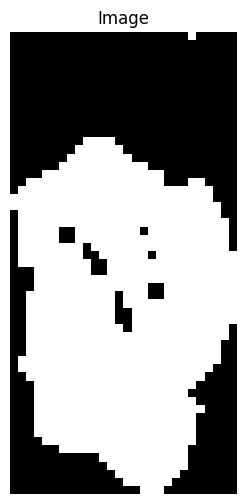

35.361328125
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (98, 91)
Bottom-right around the center: (137, 180)


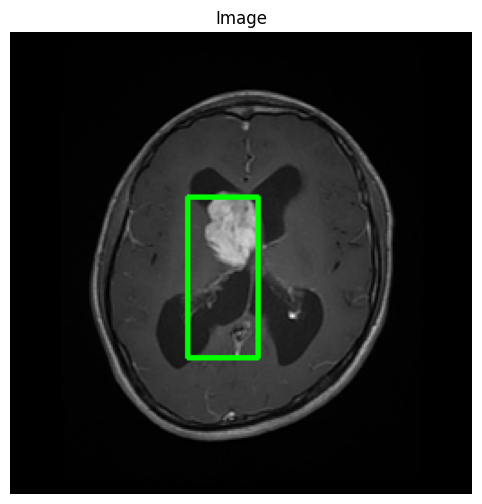

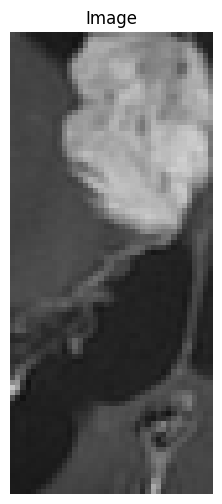

108.66015625


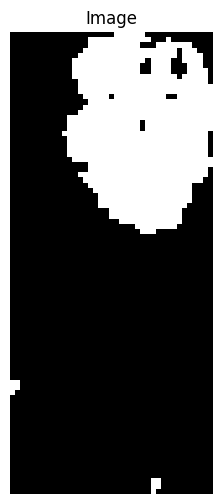

43.330078125
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (90, 92)
Bottom-right around the center: (137, 158)


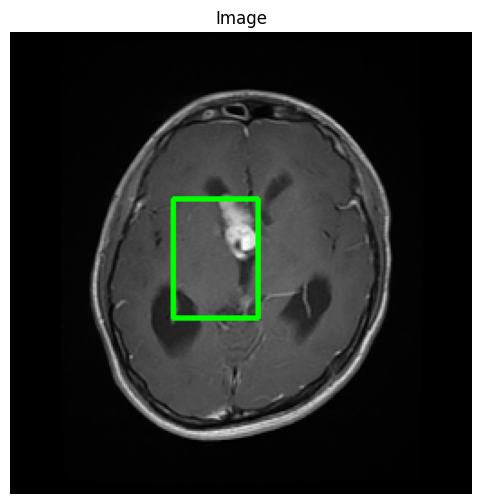

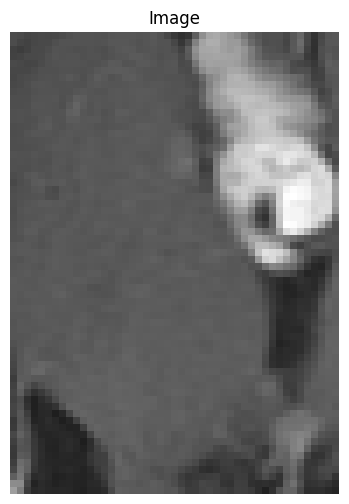

134.150390625


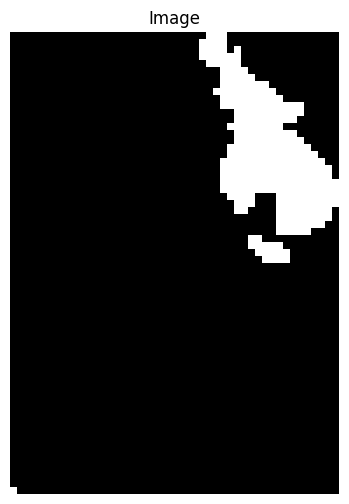

35.361328125
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (98, 91)
Bottom-right around the center: (137, 180)


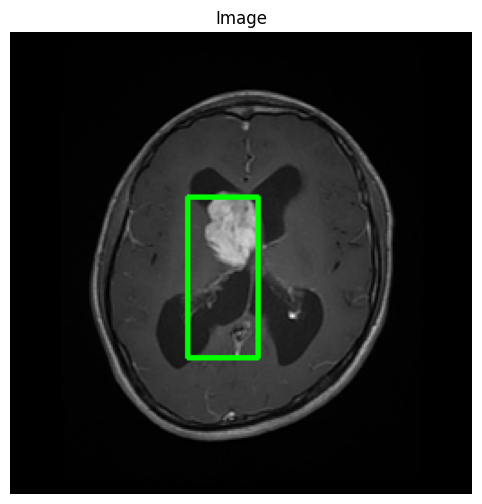

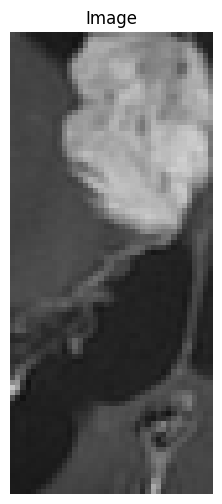

108.66015625


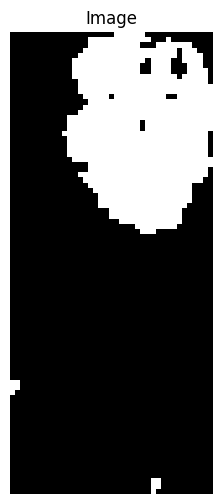

40.341796875
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (109, 75)
Bottom-right around the center: (137, 132)


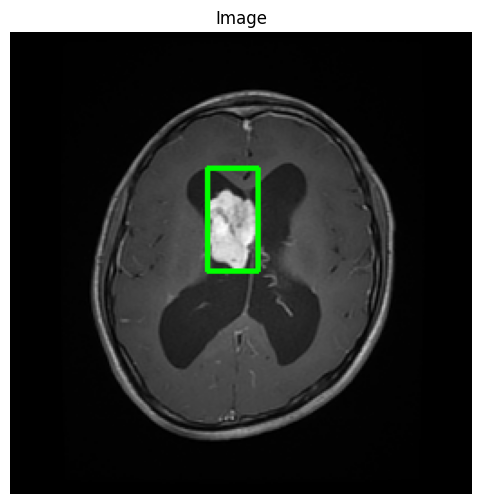

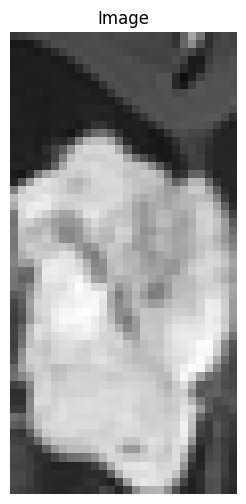

128.80078125


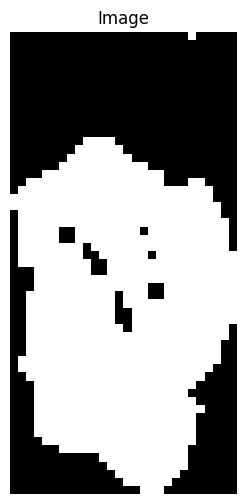

41.337890625
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (112, 89)
Bottom-right around the center: (137, 183)


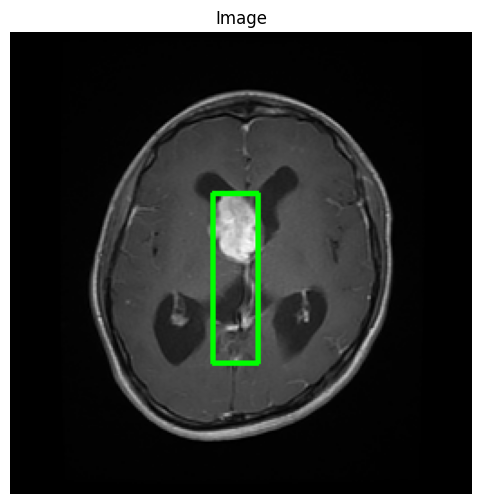

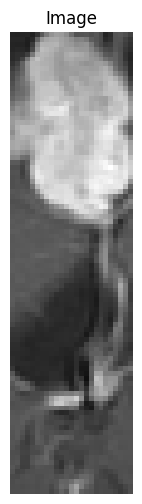

129.84375


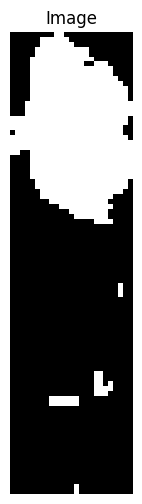

41.337890625
center_x 128
center_y 128
approx_x 38.4
approx_y 64.0
Top-left around the center: (116, 82)
Bottom-right around the center: (132, 165)


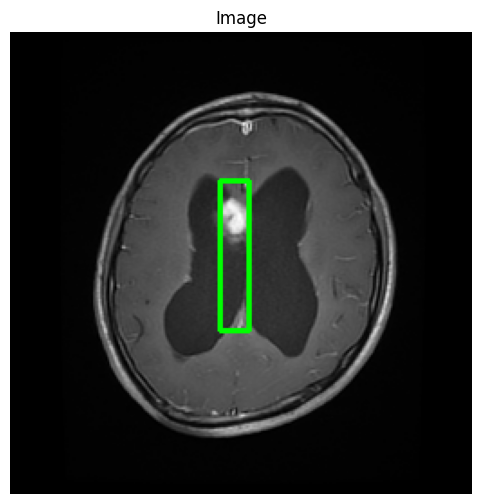

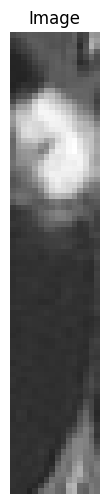

128.2421875


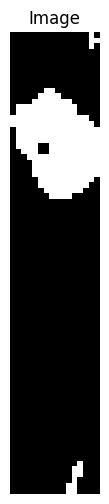

In [54]:
for img in list_read_img:
    predict_tumor_segmentation(img)

41.337890625


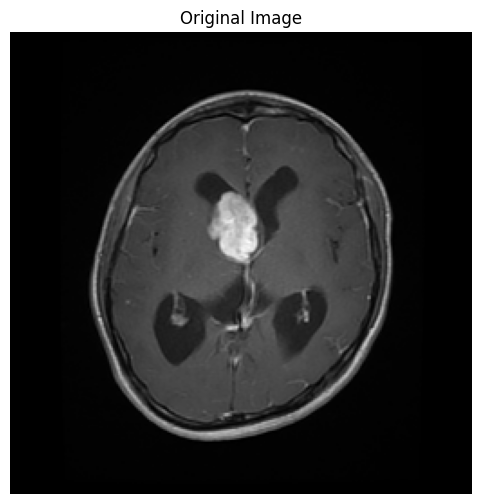

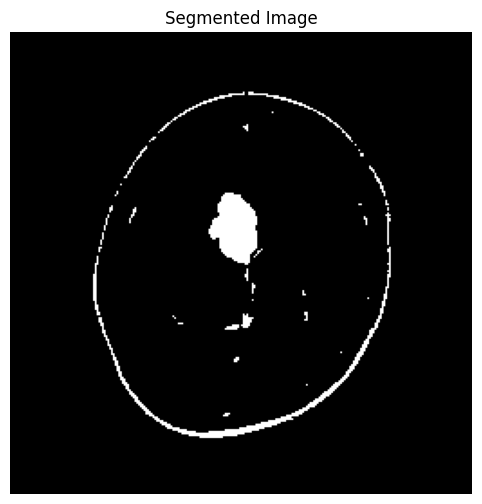

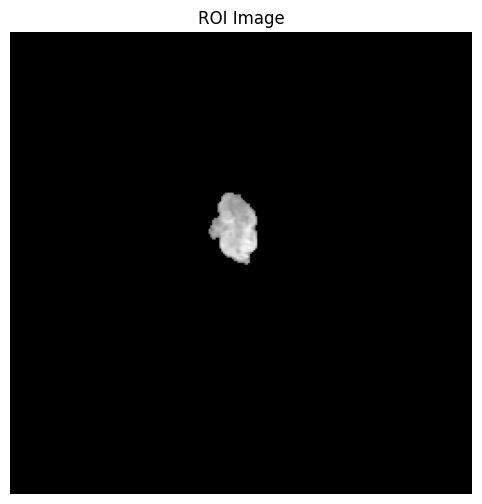

41.337890625


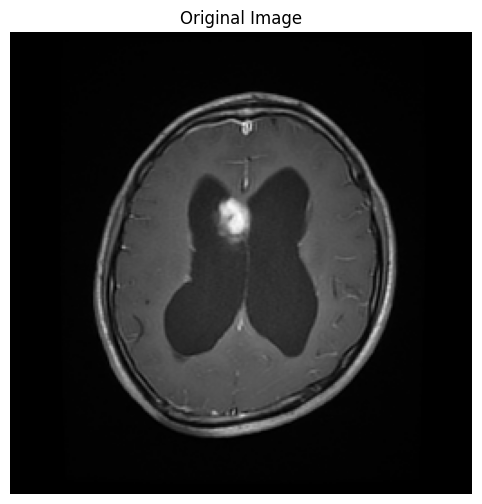

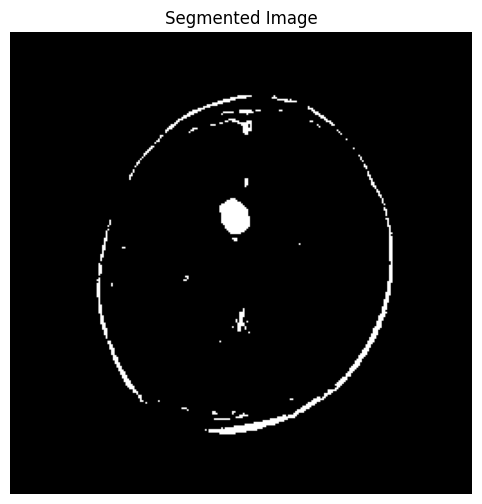

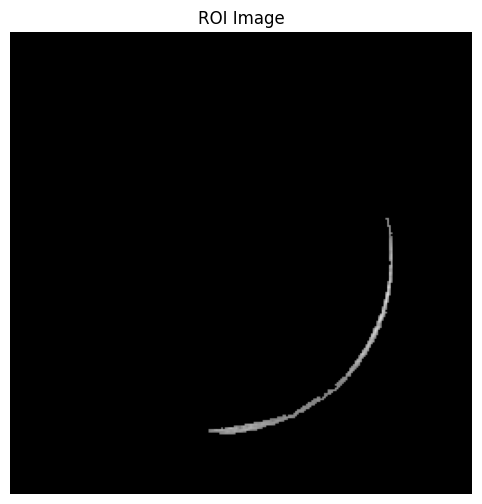

43.330078125


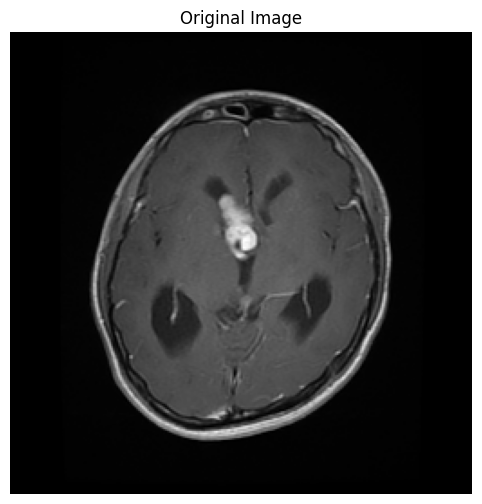

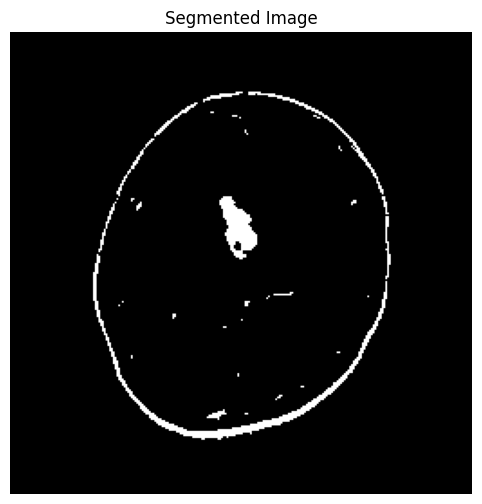

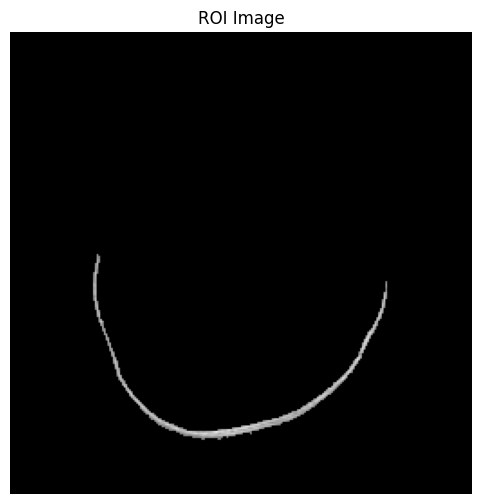

38.349609375


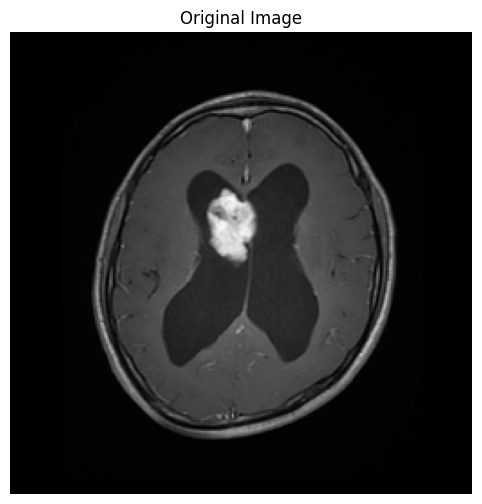

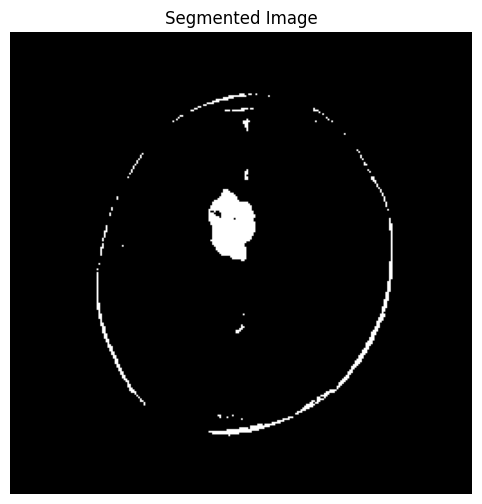

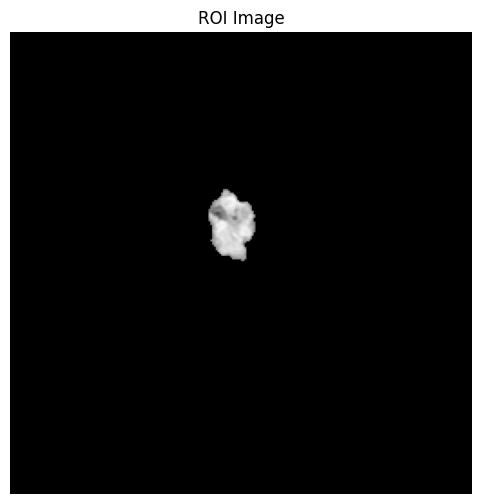

40.341796875


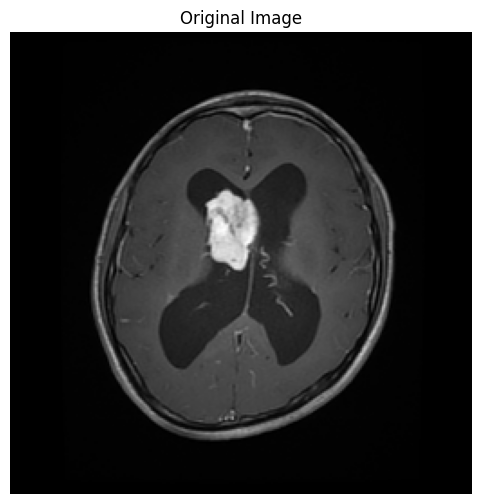

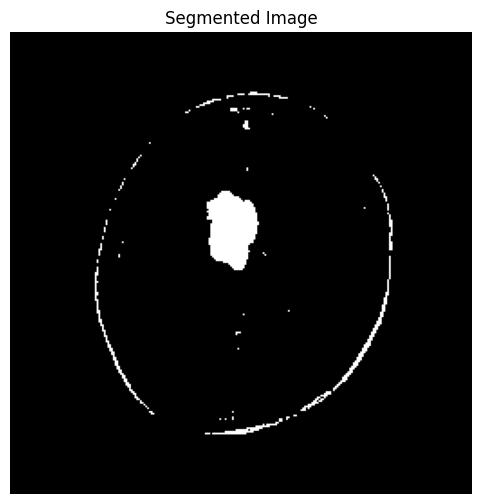

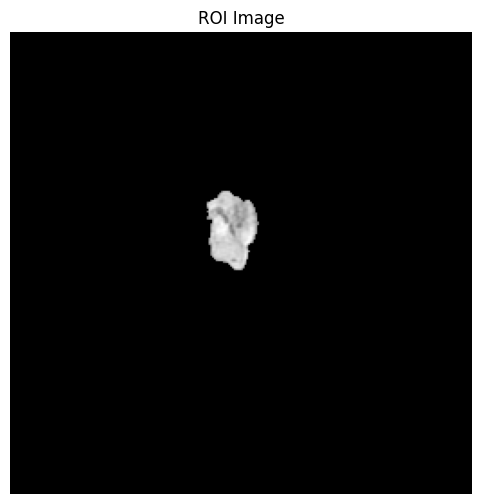

35.361328125


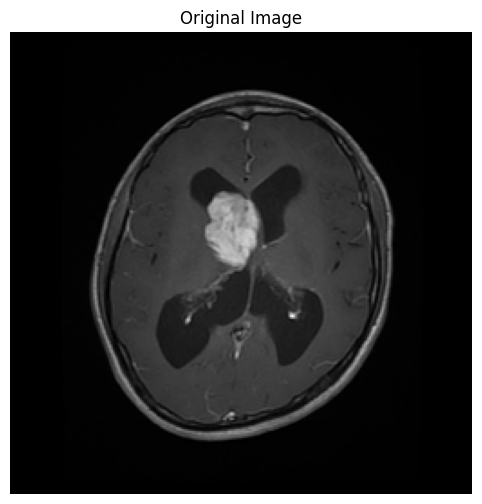

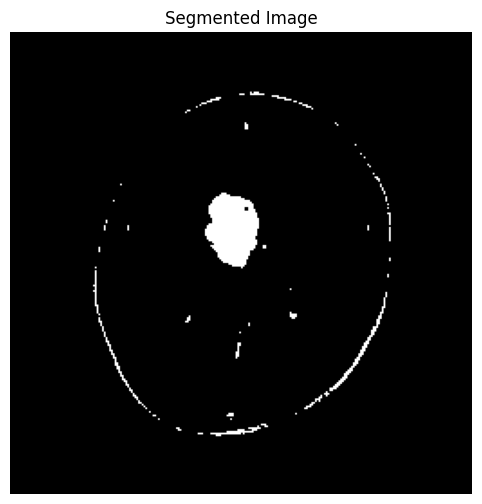

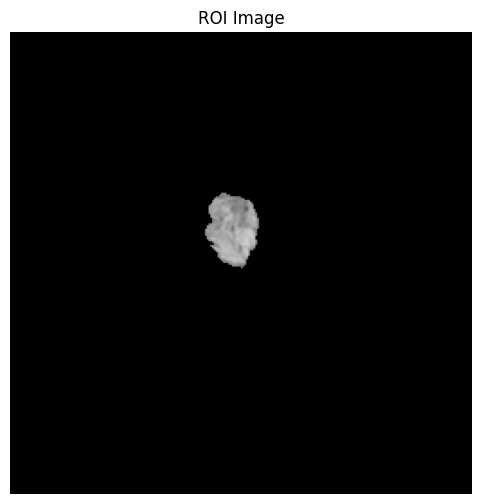

43.330078125


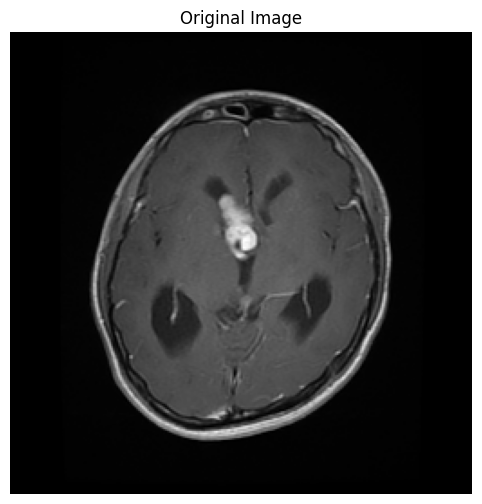

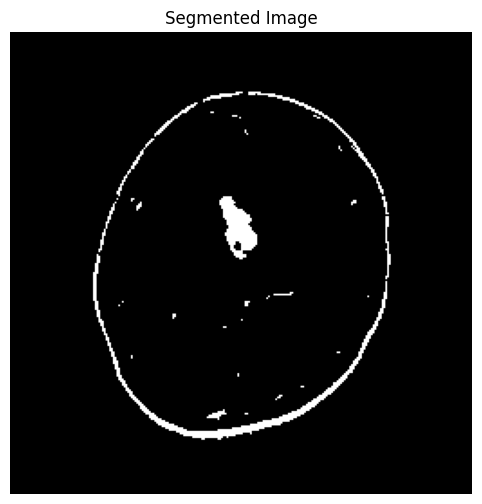

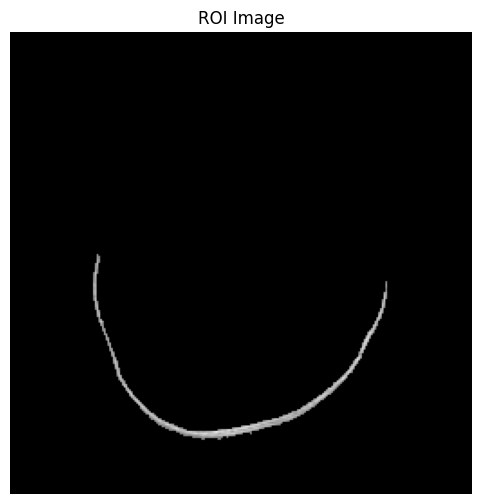

35.361328125


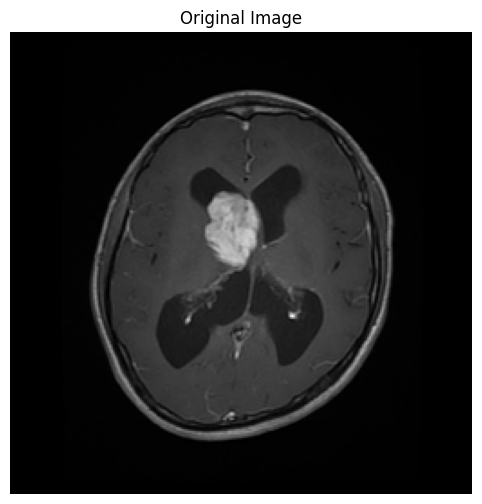

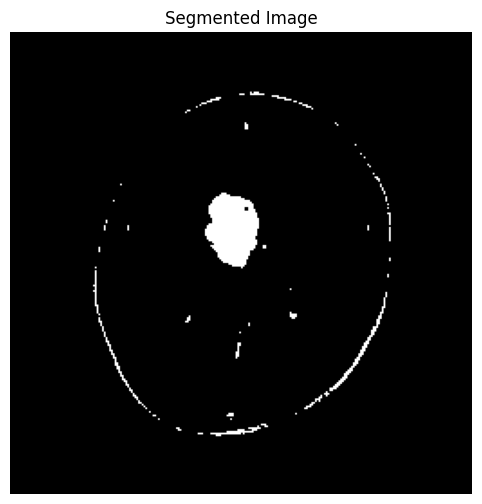

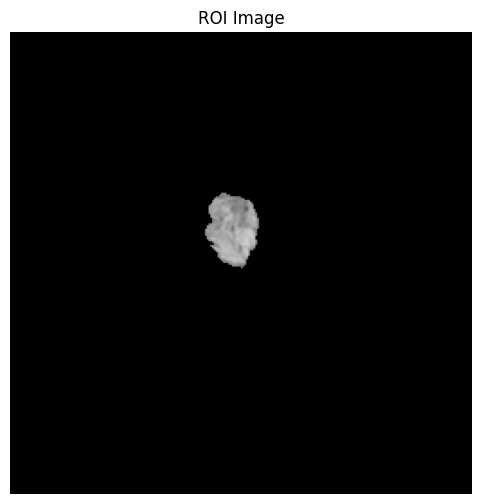

40.341796875


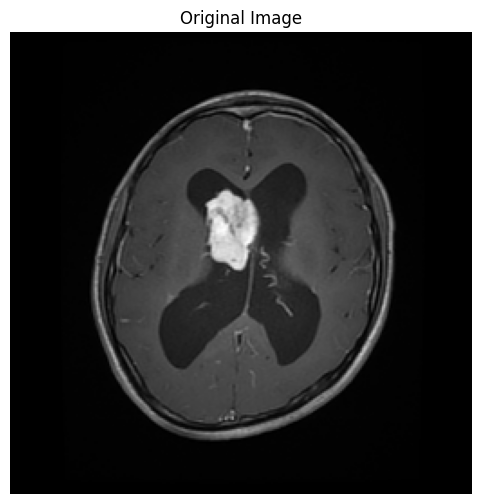

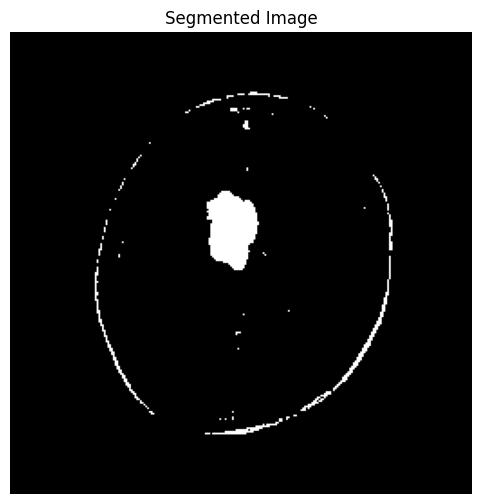

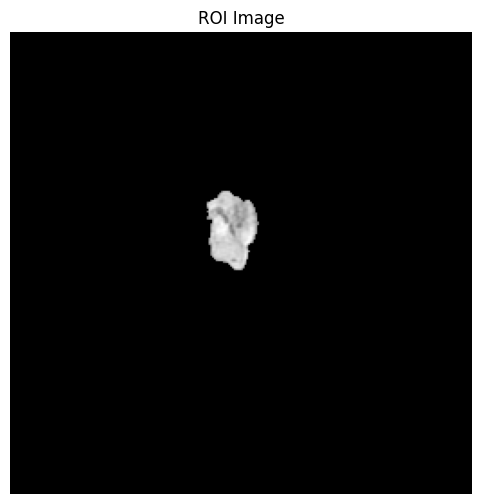

41.337890625


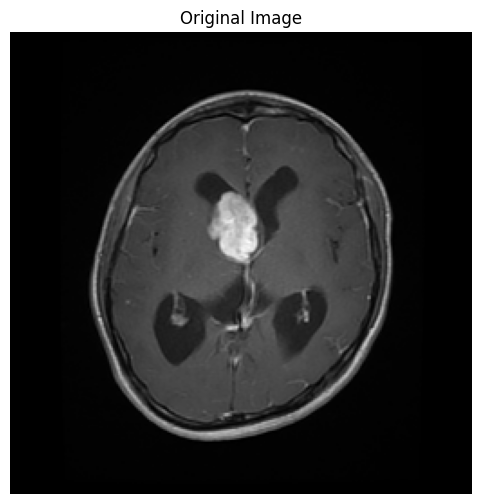

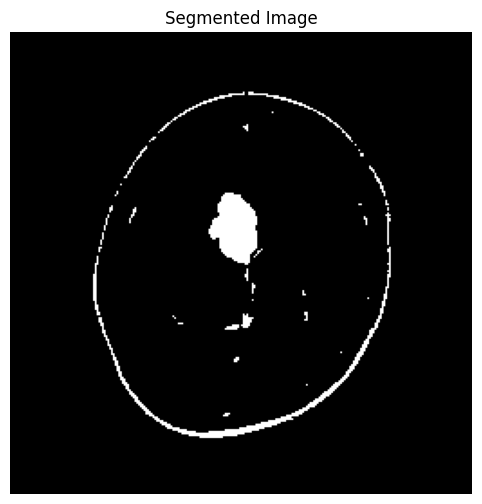

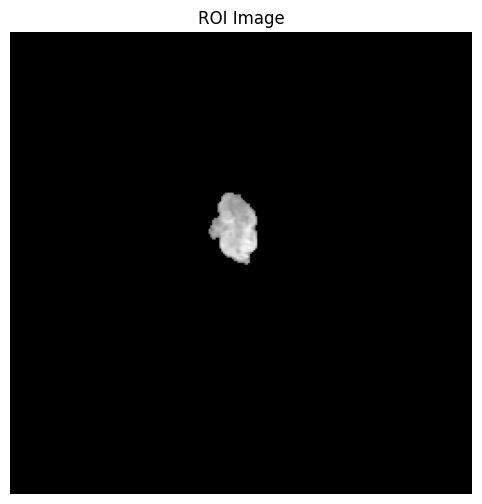

41.337890625


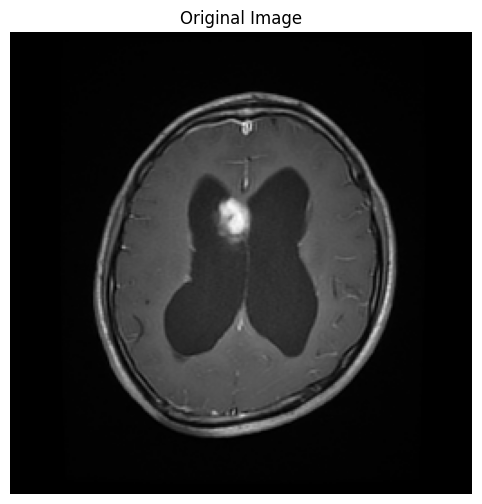

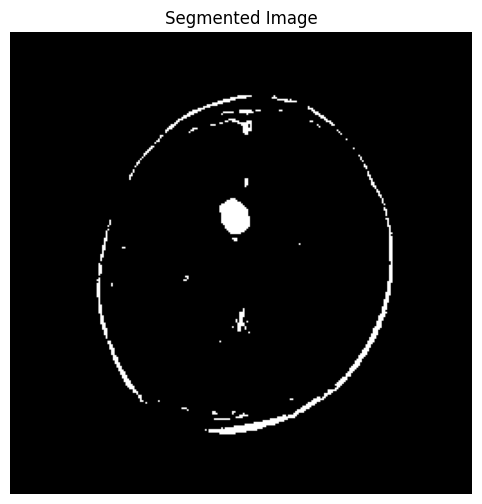

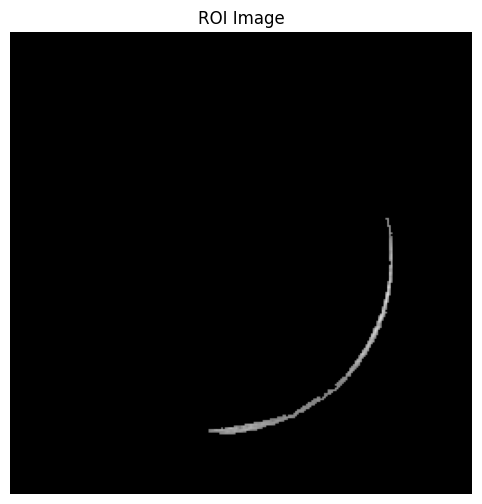

In [13]:
for img in list_read_img:
    segmented_image = image_segmentation_using_otsu_threshold(img, offset=80)

    roi_image = cv2.bitwise_and(img, img, mask=segmented_image)
    # Find contours in the segmented image
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # print(contours)
    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)
    # print(largest_contour)

    # Create an empty mask to draw the largest contour
    largest_contour_mask = np.zeros_like(segmented_image)
    cv2.drawContours(largest_contour_mask, [largest_contour], 0, 255, thickness=cv2.FILLED)

    # Extract the largest region from the original image
    largest_region = cv2.bitwise_and(img, img, mask=largest_contour_mask)

    plot_img(img, title="Original Image")
    plot_img(segmented_image, title="Segmented Image")
    plot_img(largest_region, title="ROI Image")

In [14]:


# Find contours in the segmented image
contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with the largest area
largest_contour = max(contours, key=cv2.contourArea)

# Create an empty mask to draw the largest contour
largest_contour_mask = np.zeros_like(segmented_image)
cv2.drawContours(largest_contour_mask, [largest_contour], 0, 255, thickness=cv2.FILLED)

# Extract the largest region from the original image
largest_region = cv2.bitwise_and(image, image, mask=largest_contour_mask)


NameError: name 'image' is not defined